<a href="https://colab.research.google.com/github/nickwan/nw-bootcamp-2023/blob/main/loading_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pybaseball 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.0/420.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 62.8 MB/s eta 0:00:00


In [2]:
project_dir = "drive/My Drive/nwbc/2023-05"

In [24]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as bb 

In [4]:
# df = bb.statcast(start_dt='2022-03-31', end_dt='2023-04-10')
df = pd.read_csv(f"{project_dir}/data.csv")
df.shape

(820760, 93)

In [5]:
batter_bio = bb.playerid_reverse_lookup(df['batter'].unique().tolist())
batter_bio['batter_name'] = batter_bio['name_last'].add(', ').add(batter_bio['name_first'])
df = df.merge(batter_bio.loc[:, ['key_mlbam','batter_name']].rename(columns={'key_mlbam':'batter'}), how='left')
df = df.rename(columns={'player_name':'pitcher_name'})
df.to_csv(f"{project_dir}/data.csv", index=False)

Gathering player lookup table. This may take a moment.


In [6]:
reds = df.loc[(df['home_team']=='CIN') | (df['away_team']=='CIN')]
reds.to_csv(f'{project_dir}/reds.csv', index=False)

In [7]:
df['strikes'].unique()

array([2, 1, 0, 3])

In [8]:
df['strikes'].value_counts()

0    333829
1    246210
2    240720
3         1
Name: strikes, dtype: int64

finding data in sheets  
  
formula  
pivot table  
H/VLOOKUP   
filtering   

pandas:
.loc notation  
query notation   


describe data  
aggregate columns (pivot tables?)  
summary stat output  

pandas:  
.describe()
.hist()

make new columns of data  
`=IF(ISNUMBER(FIND("strike", J19))=TRUE, 1,0)`  



In [9]:
reds["is_strike"] = 0
(reds
 .loc[reds['description']
      .isin(['called_strike', 'foul','swinging_strike', 
             'swinging_strike_blocked','foul_bunt', 
             'foul_tip','missed_bunt', 'bunt_foul_tip']),
      'is_strike']) = 1


<ipython-input-9-91ba408a87ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reds["is_strike"] = 0


In [13]:
reds.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,batter_name,is_strike
819,ST,2023-04-09,83.1,-1.39,5.73,"Gibaut, Ian",664761,664139,field_out,hit_into_play,...,4,4,6,Standard,Standard,77.0,-0.014,-0.108,"bohm, alec",0
820,FF,2023-04-09,96.4,-1.04,5.91,"Gibaut, Ian",681082,664139,strikeout,called_strike,...,4,4,6,Strategic,Standard,207.0,-0.029,-0.119,"stott, bryson",1
821,FC,2023-04-09,91.9,-1.33,5.72,"Gibaut, Ian",681082,664139,NaN,foul,...,4,4,6,Standard,Standard,187.0,0.000,-0.039,"stott, bryson",1
822,CH,2023-04-09,87.4,-1.34,5.60,"Gibaut, Ian",681082,664139,NaN,ball,...,4,4,6,Standard,Standard,242.0,0.000,0.018,"stott, bryson",0
823,FF,2023-04-09,96.1,-1.01,5.88,"Gibaut, Ian",681082,664139,NaN,called_strike,...,4,4,6,Standard,Standard,202.0,0.000,-0.036,"stott, bryson",1


In [22]:
_df = (reds
 .loc[((reds['away_team']=='CIN') & 
       (reds['inning_topbot']=='Bot')) | 
      ((reds['home_team']=='CIN') & 
       (reds['inning_topbot']=='Top')), 
      ['pitcher_name', 'pitch_name', 'is_strike']]
 .groupby(['pitcher_name', 'pitch_name'], 
          as_index=False)
 .count()
 .rename(columns={'is_strike':'n_pitches'}))


df_strikes = (reds
 .loc[((reds['away_team']=='CIN') & 
       (reds['inning_topbot']=='Bot')) | 
      ((reds['home_team']=='CIN') & 
       (reds['inning_topbot']=='Top')), 
      ['pitcher_name', 'pitch_name', 'is_strike']]
 .groupby(['pitcher_name', 'pitch_name'], 
          as_index=False)
 .mean()
 .merge(_df))

(df_strikes
 .loc[df_strikes['n_pitches']>100]
 .sort_values('is_strike', ascending=False))

,pitcher_name,pitch_name,is_strike,n_pitches
64,"Gibaut, Ian",4-Seam Fastball,0.550296,338
13,"Castillo, Luis",4-Seam Fastball,0.543668,458
1,"Anderson, Chase",Changeup,0.542857,140
50,"Díaz, Alexis",Slider,0.531646,395
99,"Lodolo, Nick",Sinker,0.526733,505
...,...,...,...,...
47,"Dunn, Justin",Slider,0.376923,130
97,"Lodolo, Nick",Changeup,0.373206,209
124,"Sanmartin, Reiver",Changeup,0.361644,365
8,"Ashcraft, Graham",Sinker,0.343669,387


In [23]:
df_plt = df_strikes.loc[df_strikes['n_pitches']>100].copy()

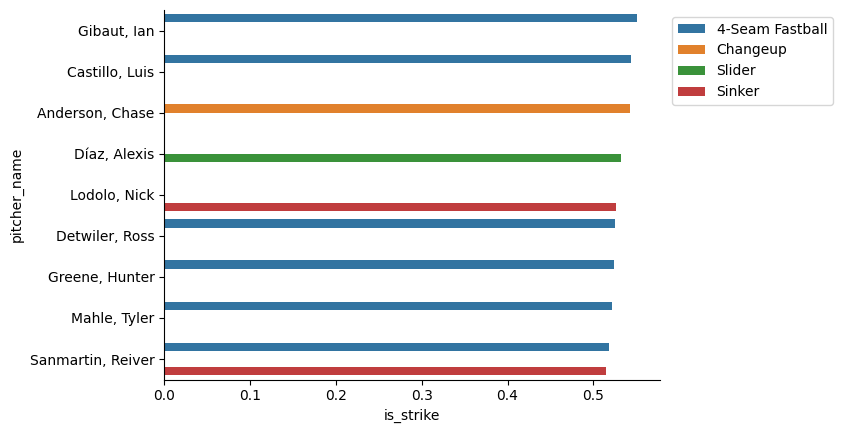

In [30]:
sns.barplot(data=df_plt.sort_values('is_strike', ascending=False).head(10), 
            x='is_strike', y='pitcher_name', hue='pitch_name', orient='h')
plt.legend(bbox_to_anchor=(1.01,1), loc=2)
sns.despine()
plt.show()

In [34]:
reds.shape

(53250, 94)

In [38]:
reds2 = reds.merge(_df)
reds2 = reds2.loc[reds2['n_pitches']>100]
reds2['runs_scored'] = reds2['post_fld_score'].sub(reds2['fld_score'])

In [36]:
reds2.loc[:,['pitcher_name', 'runs_scored']]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher_name,batter,pitcher,events,description,...,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,batter_name,is_strike,n_pitches
0,ST,2023-04-09,83.1,-1.39,5.73,"Gibaut, Ian",664761,664139,field_out,hit_into_play,...,4,6,Standard,Standard,77.0,-0.014,-0.108,"bohm, alec",0,118
1,ST,2023-04-09,85.3,-1.27,5.77,"Gibaut, Ian",592206,664139,NaN,ball,...,4,6,Standard,Standard,88.0,0.000,0.031,"castellanos, nick",0,118
2,ST,2023-04-08,80.8,-1.60,5.74,"Gibaut, Ian",624641,664139,sac_fly,hit_into_play,...,2,2,Strategic,Standard,71.0,-0.011,-0.285,"sosa, edmundo",0,118
3,ST,2023-04-04,83.8,-1.59,5.67,"Gibaut, Ian",543228,664139,NaN,foul,...,2,3,Standard,Standard,78.0,0.000,-0.127,"gomes, yan",1,118
4,ST,2023-04-03,82.6,-1.82,5.82,"Gibaut, Ian",641820,664139,NaN,foul,...,3,4,Standard,Standard,79.0,0.000,-0.162,"mancini, trey",1,118


In [10]:
reds.columns.values

array(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'pitcher_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4',
       'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release_pos_y', 'estim